In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# compute base forecast no coherent
from statsforecast.models import AutoARIMA
from statsforecast.core import StatsForecast

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation


In [3]:
df = pd.read_csv('C:\\Users\\IqraImtiaz\\OneDrive - keystonestrategy.com\\Documents\\Moderna\\IQVIA\\iqvia_zip.csv')
df['Date'] = pd.to_datetime(df['Date'])

data = df
data = data.dropna()
data = data.dropna(subset=['PROVIDER_ZIP'])
data["PROVIDER_ZIP"] = data["PROVIDER_ZIP"].astype(str).str.strip()
data = data[data['PROVIDER_ZIP'] != "\"\""]
data["PROVIDER_ZIP"] = data["PROVIDER_ZIP"].str.replace("\"","")
data = data.sort_values(by=['PROVIDER_ZIP', 'Date'])

data['zip'] = data['PROVIDER_ZIP'].astype(str).str.split('.',expand=True)[0]
data['zip'] = np.where(data['zip'].str.len()==3,'00'+data['zip'],np.where(data['zip'].str.len()==4,'0'+data['zip'],data['zip']))
data['zip3'] = data['zip'].str.slice(stop=3)
data = data[['Date','zip3','CLM_CNT']]
data = data.groupby(['zip3','Date']).sum()

# filter on xip codes that have at least 10 data points
data = data.groupby('zip3').filter(lambda x: len(x)>10)
data.reset_index(inplace=True)

grouped_sum = data.groupby('Date')['CLM_CNT'].transform('sum')
data['natl_admins'] = grouped_sum
data['shares'] = (data['CLM_CNT'] / data['natl_admins'])
df = data

In [4]:
# Create a complete set of all possible combinations of zip3 and dates
all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='W-FRI')
all_zip3 = df['zip3'].unique()
complete_index = pd.MultiIndex.from_product([all_zip3, all_dates], names=['zip3', 'Date'])

# Reindex the DataFrame to include all combinations, filling missing values with zeros
df_complete = df.set_index(['zip3', 'Date']).reindex(complete_index, fill_value=0).reset_index()

In [12]:

# Generate the dataset to match the Australian Domestic Tourism example
data = df_complete[['zip3', 'Date', 'CLM_CNT']].rename(columns={'zip3': 'unique_id', 'Date': 'ds', 'CLM_CNT': 'y'})

# Define the hierarchical structure (this is similar to the 'spec' you used)
spec = [
    ['unique_id']
]

# Aggregate data according to the hierarchy
Y_df, S_df, tags = aggregate(data, spec)
Y_df = Y_df.reset_index()


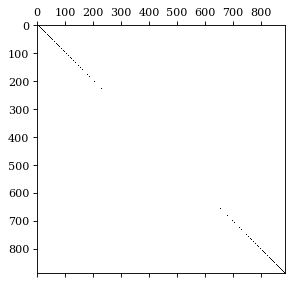

In [13]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()


TypeError: 'Axes' object is not subscriptable

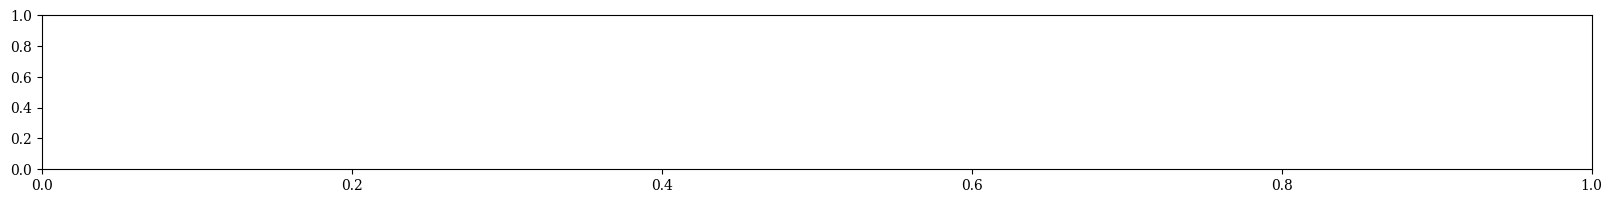

In [20]:
hplot.plot_hierarchically_linked_series(
    bottom_series='999',
    Y_df=Y_df.set_index('unique_id')
)


In [21]:

# Train/test split
Y_test_df = Y_df.groupby('unique_id').tail(8)
Y_train_df = Y_df.drop(Y_test_df.index)

Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

# Fit the model with prediction intervals
models = [
    AutoARIMA(season_length=7),
]
fcst = StatsForecast(df=Y_train_df, models=models, freq='W', n_jobs=-1)
h = 8  # Forecast horizon of 8 weeks

c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\statsforecast\core.py:474: FutureWarning:

The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.

c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\statsforecast\core.py:626: FutureWarning:

Passing unique_id as the index is deprecated. Please provide it as a column instead.

c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\statsforecast\core.py:474: FutureWarning:

The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.

c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\statsforecast\core.py:492: FutureWarning:

In a future vers

In [24]:
Y_hat_df = fcst.forecast(h=8, fitted=True, level=[80, 90])

Y_fitted_df = fcst.forecast_fitted_values()

c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\statsforecast\core.py:474: FutureWarning:

The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.

c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\statsforecast\core.py:492: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\statsforecast\core.py:492: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



In [25]:
# Reconcile forecasts using MinTrace and BottomUp
reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols'),
]

hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, 
                          S=S_df, tags=tags, level=[80, 90])

In [26]:
Y_rec_df.head()


,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-90,AutoARIMA/BottomUp,AutoARIMA/BottomUp-lo-90,AutoARIMA/BottomUp-lo-80,AutoARIMA/BottomUp-hi-80,...,AutoARIMA/MinTrace_method-mint_shrink,AutoARIMA/MinTrace_method-mint_shrink-lo-90,AutoARIMA/MinTrace_method-mint_shrink-lo-80,AutoARIMA/MinTrace_method-mint_shrink-hi-80,AutoARIMA/MinTrace_method-mint_shrink-hi-90,AutoARIMA/MinTrace_method-ols,AutoARIMA/MinTrace_method-ols-lo-90,AutoARIMA/MinTrace_method-ols-lo-80,AutoARIMA/MinTrace_method-ols-hi-80,AutoARIMA/MinTrace_method-ols-hi-90
unique_id,,,,,,,,,,,,,,,,,,,,,
006,2023-12-03,1054.997192,-1020.737366,-562.265747,2672.260254,3130.731689,1054.997192,-1020.737408,-562.265817,2672.260201,...,1054.997184,-1020.737414,-562.265823,2672.260191,3130.731782,1054.997192,-1020.737408,-562.265817,2672.260201,3130.731792
006,2023-12-10,1047.479858,-2032.670044,-1352.351318,3447.311035,4127.629883,1047.479858,-2032.670192,-1352.351382,3447.311099,...,1047.479852,-2032.670195,-1352.351386,3447.311089,4127.629899,1047.479858,-2032.670192,-1352.351382,3447.311099,4127.629909
006,2023-12-17,1076.164062,-2875.530762,-2002.712036,4155.040039,5027.858887,1076.164062,-2875.530918,-2002.712262,4155.040387,...,1076.164057,-2875.530918,-2002.712263,4155.040377,5027.859032,1076.164062,-2875.530918,-2002.712262,4155.040387,5027.859043
006,2023-12-24,1116.915527,-3655.329590,-2601.274414,4835.105469,5889.160645,1116.915527,-3655.329704,-2601.274497,4835.105552,...,1116.915523,-3655.329702,-2601.274497,4835.105542,5889.160748,1116.915527,-3655.329704,-2601.274497,4835.105552,5889.160758
006,2023-12-31,1163.030273,-4408.555176,-3177.947998,5504.008301,6734.615234,1163.030273,-4408.555190,-3177.948131,5504.008678,...,1163.030269,-4408.555187,-3177.948130,5504.008669,6734.615726,1163.030273,-4408.555190,-3177.948131,5504.008678,6734.615737


In [27]:
plot_df = pd.concat([Y_df.set_index(['unique_id', 'ds']), 
                     Y_rec_df.set_index('ds', append=True)], axis=1)
plot_df = plot_df.reset_index('ds')


ValueError: operands could not be broadcast together with shapes (0,) (8,) 

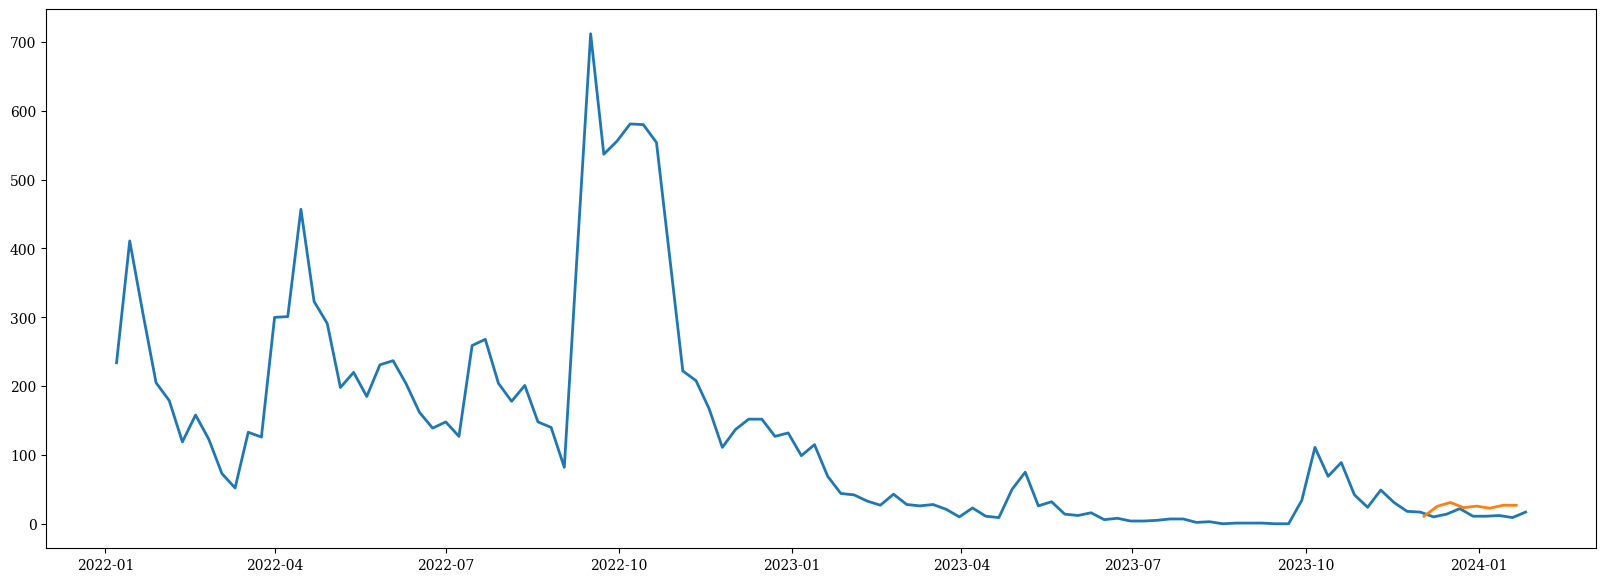

In [28]:
hplot.plot_series(
    series='999',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA', 'AutoARIMA/MinTrace_method-ols'],
    level=[80]
)


ValueError: operands could not be broadcast together with shapes (0,) (8,) 

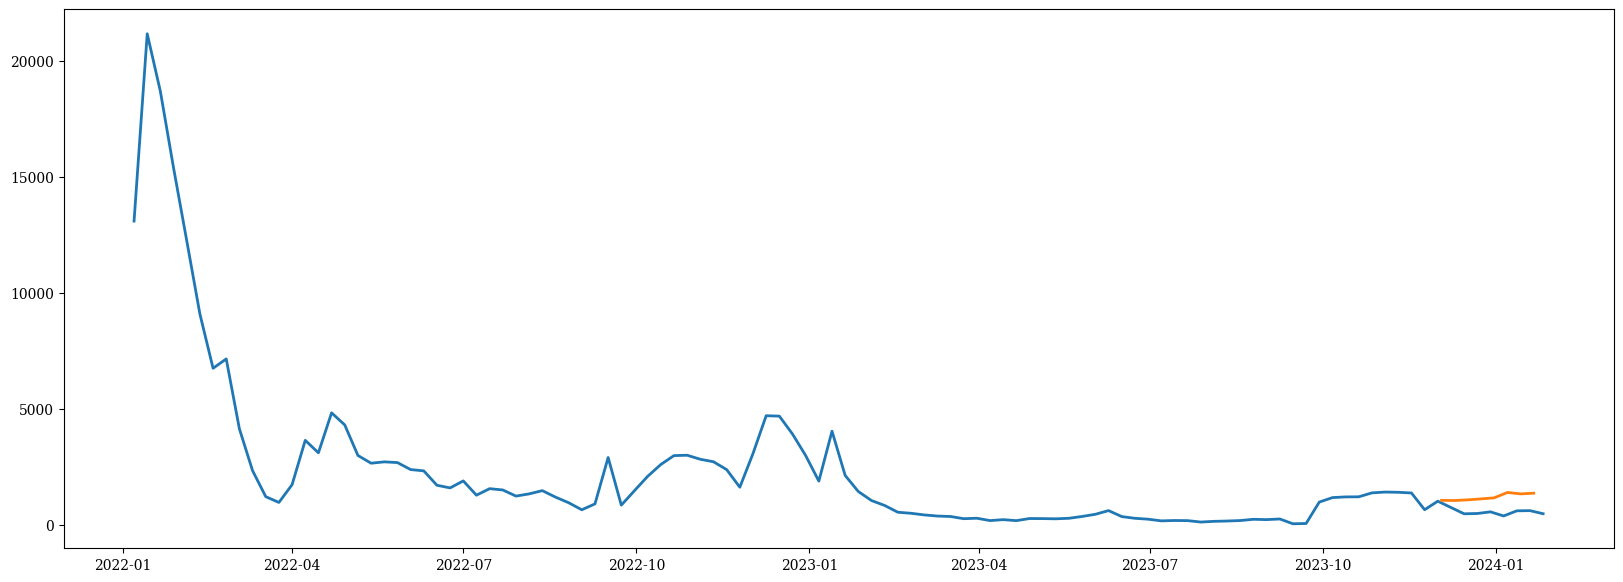

In [30]:
# Since we are plotting a bottom time series
# the probabilistic and mean forecasts
# are the same
hplot.plot_series(
    series='006',
    Y_df=plot_df, 
    models=['y', 'AutoARIMA', 'AutoARIMA/BottomUp'],
    level=[80]
)


In [34]:
def rmse(y, y_hat):
    return np.mean(np.sqrt(np.mean((y-y_hat)**2, axis=1)))

def mase(y, y_hat, y_insample, seasonality=7):
    errors = np.mean(np.abs(y - y_hat), axis=1)
    scale = np.mean(np.abs(y_insample[:, seasonality:] - y_insample[:, :-seasonality]), axis=1)
    return np.mean(errors / scale)

def mape(y, y_hat):
    m = np.mean(np.abs((y - y_hat) / (y + np.finfo(float).eps)), axis=1)
    return np.mean(m * 100)

eval_tags = {}
eval_tags['zip3'] = tags['unique_id']
eval_tags['All'] = np.concatenate(list(tags.values()))

evaluator = HierarchicalEvaluation(evaluators=[rmse, mase, mape])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df,
        tags=eval_tags, Y_df=Y_train_df
)
evaluation = evaluation.drop('Overall')
#evaluation.columns = ['Base', 'BottomUp', 'MinTrace(mint_shrink)', 'MinTrace(ols)']
evaluation = evaluation.applymap('{:.2f}'.format)
evaluation

C:\Users\IqraImtiaz\AppData\Local\Temp\ipykernel_15456\678999635.py:22: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

C:\Users\IqraImtiaz\AppData\Local\Temp\ipykernel_15456\678999635.py:24: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



AutoARIMA        AutoARIMA-lo-90  \
level metric                                                
zip3  rmse                  481.00                1701.26   
      mase                    0.51                   1.54   
      mape    27699729814254168.00  309553028391075072.00   
All   rmse                  481.00                1701.26   
      mase                    0.51                   1.54   
      mape    27699729814254168.00  309553028391075072.00   

                    AutoARIMA-lo-80        AutoARIMA-hi-80  \
level metric                                                 
zip3  rmse                  1243.13                2096.27   
      mase                     1.12                   2.01   
      mape    235063590267504224.00  290460860492518528.00   
All   rmse                  1243.13                2096.27   
      mase                     1.12                   2.01   
      mape    235063590267504224.00  290460860492518528.00   

                    AutoARIMA-hi-90    AutoARIMA/BottomUp  \
level metric                                                
zip3  rmse                  2564.08                481.00   
      mase                     2.44                  0.51   
      mape    364950300342933568.00  27699729814254168.00   
All   rmse                  2564.08                481.00   
      mase                     2.44                  0.51   
      mape    364950300342933568.00  27699729814254168.00   

             AutoARIMA/BottomUp-lo-90 AutoARIMA/BottomUp-lo-80  \
level metric                                                     
zip3  rmse                    1701.26                  1243.13   
      mase                       1.54                     1.12   
      mape      309553033926397184.00    235063593226008864.00   
All   rmse                    1701.26                  1243.13   
      mase                       1.54                     1.12   
      mape      309553033926397184.00    235063593226008864.00   

             AutoARIMA/BottomUp-hi-80 AutoARIMA/BottomUp-hi-90  \
level metric                                                     
zip3  rmse                    2096.27                  2564.08   
      mase                       2.01                     2.44   
      mape      290460864171515136.00    364950304871903616.00   
All   rmse                    2096.27                  2564.08   
      mase                       2.01                     2.44   
      mape      290460864171515136.00    364950304871903616.00   

             AutoARIMA/MinTrace_method-mint_shrink  \
level metric                                         
zip3  rmse                                  481.00   
      mase                                    0.51   
      mape                    27699729787944028.00   
All   rmse                                  481.00   
      mase                                    0.51   
      mape                    27699729787944028.00   

             AutoARIMA/MinTrace_method-mint_shrink-lo-90  \
level metric                                               
zip3  rmse                                       1701.26   
      mase                                          1.54   
      mape                         309553033930397952.00   
All   rmse                                       1701.26   
      mase                                          1.54   
      mape                         309553033930397952.00   

             AutoARIMA/MinTrace_method-mint_shrink-lo-80  \
level metric                                               
zip3  rmse                                       1243.13   
      mase                                          1.12   
      mape                         235063593261372896.00   
All   rmse                                       1243.13   
      mase                                          1.12   
      mape                         235063593261372896.00   

             AutoARIMA/MinTrace_method-mint_shrink-hi-80  \
level metric                         